<a href="https://colab.research.google.com/github/Zhr-Srj/TripSimAcin-AMR/blob/main/TripSimAcin_AMR_validation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we want to train TSA-Net model and validate it 10 times and get an average over validation metrics' values.

This file includes results mentioned in Table 4 and Table 5

# Required packages

In [ ]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random
from random import sample, shuffle

from sklearn.utils import shuffle as sk_shuffle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold

from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.callbacks import  History

# Data

## Loading dataset with SHAP selected features

In [ ]:
with open(r'/content/drive/MyDrive/Dataset_SHAP_u.txt') as f:
    data = []
    for line in f.readlines():
        row = []
        for elem in line.split(sep=','):
            row.append(int(elem.strip()))
        data.append(row)
print(len(data))
print(len(data[0]))

6630
2996


In [ ]:
#Reading phenotypes file
with open(r'/content/drive/MyDrive/DrugLabel_SHAP_u.txt') as fy:
    labels = []
    drugs = [] #stores drug name in each row
    row = 0 # row number of each label (is needed because data is reordered while spliting)
    reader = csv.reader(fy)
    for i in reader:
        labels.append([row, int(i[1])])
        drugs.append(i[0])
        row += 1

print(len(labels))
print(len(drugs))
print(labels[:5])

6630
6630
[[0, 1], [1, 0], [2, 0], [3, 1], [4, 1]]


In [ ]:
labels = np.asarray(labels)

## A survey on data

In [ ]:
unq_drugs = set(drugs)
len(unq_drugs)

12

In [ ]:
per_drug_dic = {}
for i, drug in enumerate(drugs):
  if drug not in per_drug_dic.keys():
    per_drug_dic[drug] = [0, 0]  # num of resistant, num of susceptible
  if labels[i][1] == 0:
    per_drug_dic[drug][1] += 1
  else:
    per_drug_dic[drug][0] += 1

per_drug_dic

{'ciprofloxacin': [651, 97],
 'doripenem': [51, 148],
 'gentamicin': [572, 94],
 'tetracycline': [511, 182],
 'cefotaxime': [568, 31],
 'meropenem': [166, 172],
 'imipenem': [196, 508],
 'amikacin': [300, 394],
 'levofloxacin': [459, 146],
 'ceftriaxone': [633, 34],
 'ceftazidime': [526, 105],
 'moxifloxacin': [57, 29]}

In [ ]:
keys = []
for element in data:
  if np.asarray(element[:2693]).tobytes() not in keys:
    keys.append(np.asarray(element[:2693]).tobytes())

print("Number of strains in dataset", len(keys))

Number of strains in dataset 766


# Required functions

In [ ]:
def balanced_train_test_split(data, labels, drugs, n):
  """
  Performs a train_test_split, setting n susceptibles and n resistant strains aside for each drug as test set
  returns x_train, x_test, y_train, y_test
  """

  data, labels = sk_shuffle(data, labels)

  x_train = []
  x_test = []
  y_train = []
  y_test = []

  idx = {} # A dic containig indices of susceptible and resistant strains
            # for each drug

  unq_drugs = list(set(drugs))

  for drug_name in unq_drugs:
    drug_indx_S = []
    drug_indx_R = []
    for i in range(len(labels)):
      j, l = labels[i][0], labels[i][1]
      if drugs[j] == drug_name:
        if l == 0:
          drug_indx_S.append(i)
        else:
          drug_indx_R.append(i)
    idx[(drug_name, 'S')] = drug_indx_S
    idx[(drug_name, 'R')] = drug_indx_R

  len_xtrain = 0
  len_xtest = 0

  for drug in unq_drugs:

    s_set = idx[(drug, 'S')]
    for i in range(len(s_set)-n):
      x_train.append(data[s_set[i]])
      y_train.append(labels[s_set[i]])
    for i in range(1, n+1):
      x_test.append(data[s_set[-i]])
      y_test.append(labels[s_set[-i]])

    r_set = idx[(drug, 'R')]
    for i in range(len(r_set)-n):
      x_train.append(data[r_set[i]])
      y_train.append(labels[r_set[i]])
    for i in range(1, n+1):
      x_test.append(data[r_set[-i]])
      y_test.append(labels[r_set[-i]])

    # For confirming it's working properly
    print("for drug ", drug, "# of train samples: ", len(x_train)-len_xtrain, )
    len_xtrain = len(x_train)
    print("for drug ", drug, "# of test samples: ", len(x_test)-len_xtest)
    len_xtest = len(x_test)

  return x_train, x_test, y_train, y_test

In [ ]:
def make_balanced_triplets(samples, labels, drugs, num):
  """For each drug in drugs samples...
  makes:
  - n triplets which are both Susceptible to drug (S, S)
  - n triplets which are (R, R)
  - n triplets which are (S, R)
  - n triplets which are (R, S)
  """
  bac_shape = 2693

  idx = {} # A dic containig indices of susceptible and resistant strain
            # for each drug

  triplet = [] # Made from samples which are not part of external_test_sets
  triLabels = [] # Labels corresponding to triplets

  unq_drugs = list(set(drugs))

  for drug_name in unq_drugs:
    drug_indx_S = []
    drug_indx_R = []
    for i in range(len(labels)):
      j, l = labels[i][0], labels[i][1]
      if drugs[j] == drug_name:
        if l == 0:
          drug_indx_S.append(i)
        else:
          drug_indx_R.append(i)
    idx[(drug_name, 'S')] = drug_indx_S
    idx[(drug_name, 'R')] = drug_indx_R

  for drug in unq_drugs:

    s_len = len(idx[(drug, 'S')])
    r_len = len(idx[(drug, 'R')])
    n = min(num, int(s_len*(s_len-1)/2), int(r_len*(r_len-1)/2))

    ss = [(i, j) for i in idx[(drug, 'S')] for j in idx[(drug, 'S')] if j>i]
    ss_sampled = sample(ss, n)

    rr = [(i, j) for i in idx[(drug, 'R')] for j in idx[(drug, 'R')] if j>i]
    rr_sampled = sample(rr, n)

    rs = [(i, j) for i in idx[(drug, 'R')] for j in idx[(drug, 'S')]]
    neg_samples = sample(rs, 2*n)
    rs_sampled = neg_samples[:n]
    sr_sampled = [(t[1], t[0]) for t in neg_samples[n:]]

    for k in range(n):
      # Making (S, S, d) triplets
      triplet.append( samples[ss_sampled[k][0]][:bac_shape] + samples[ss_sampled[k][1]][:bac_shape] +
                        samples[ss_sampled[k][0]][bac_shape:] )
      triLabels.append([1, 0]) # 1: both phenos the same. First: 0, sencond? --> 0

      # Making (R, R, d) triplets
      triplet.append( samples[rr_sampled[k][0]][:bac_shape] + samples[rr_sampled[k][1]][:bac_shape] +
                        samples[rr_sampled[k][0]][bac_shape:] )
      triLabels.append([1, 1]) # 1: both phenos the same. First: 1, sencond? --> 1

      # Making (R, S, d) triplets
      triplet.append( samples[rs_sampled[k][0]][:bac_shape] + samples[rs_sampled[k][1]][:bac_shape] +
                         samples[rs_sampled[k][0]][bac_shape:])
      triLabels.append([0, 1]) # 0: phenos different. First: 1, sencond? --> 0

      # Making (S, R, d) triplets
      triplet.append( samples[sr_sampled[k][0]][:bac_shape] + samples[sr_sampled[k][1]][:bac_shape] +
                         samples[sr_sampled[k][0]][bac_shape:])
      triLabels.append([0, 0]) # 0: phenos different. First: 0, sencond? --> 1

  return np.array(triplet), np.array(triLabels)

In [ ]:
def evaluation(true_labels, pred_labels):

  Dis_pred = []
  for i in pred_labels:
    if i < 0.5:
      Dis_pred.append(0)
    else:
      Dis_pred.append(1)

  acc = accuracy_score(true_labels, Dis_pred)
  auc = roc_auc_score(true_labels, Dis_pred)
  print('Accuracy: ', acc)
  print('ROC-AUC: ', auc)

  TN, FP, FN, TP = confusion_matrix(true_labels, Dis_pred, labels=[0, 1]).ravel()
  sen = TP/(TP+FN)
  spc = TN/(TN+FP)
  print("Sensitivity: ", sen)
  print('Specificity: ', spc)

  conf_matrix = confusion_matrix(true_labels, Dis_pred, labels=[0, 1])
  plt.figure(figsize=(4, 4))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Predicted Negative', 'Predicted Positive'],
              yticklabels=['True Negative', 'True Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  return acc, auc, sen, spc

# TripSimAcin_AMR framework

## TSA_Net architecture

In [ ]:
input_shape1 = (2693,) # Strain feature length
input_shape2 = (2693,)
input_shape3 = (303,) # Antibiotic feature length

In [ ]:
def create_siamese_model(input_shape1, input_shape2, input_shape3):

    right_input = Input(shape=input_shape2)
    left_input = Input(shape=input_shape1)
    third_input = Input(shape=input_shape3)

    shared_layer1 = Dense(1024, activation='leaky_relu')
    shared_layer2 = Dense(512, activation='leaky_relu')
    shared_layer3 = Dense(256, activation='leaky_relu')
    shared_bn = BatchNormalization() # shared batch normalization layer
    drug_bn = BatchNormalization() # drug batch normalization layer

    encoded_l = shared_layer1(left_input)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_layer2(encoded_l)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_layer3(encoded_l)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_bn(encoded_l)

    encoded_r = shared_layer1(right_input)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_layer2(encoded_r)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_layer3(encoded_r)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_bn(encoded_r)

    encoded_c = Dense(256, activation='leaky_relu')(third_input)
    encoded_c = Dropout(0.2)(encoded_c)
    encoded_c = drug_bn(encoded_c)

    concatenated = Concatenate()([encoded_l, encoded_r, encoded_c])

    dense1 = Dense(128, activation='leaky_relu')(concatenated)
    dense1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='leaky_relu')(dense1)
    dense2 = Dropout(0.2)(dense2)
    prediction = Dense(1, activation='sigmoid')(dense2)

    siamese_net = Model(inputs=[left_input, right_input, third_input], outputs=prediction)

    optimizer = Adam(learning_rate=0.001)
    siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", AUC(name='auc-roc')])

    return siamese_net

# Evaluation

## Functions
Performance on queries


So each label is a list of size 2

In [ ]:
def ExternalTest(x0_test,x1_test,x0_train,x1_train):
  """
  Takes as input paired data and
  Pairs each test sample with train samples of the same drug (triplet --> b1, b2, d).
  x0_test: test samples with phenotype 0
  x1_test: test samples with phenotype 1
  x0_train: train samples with phenotype 0
  x1_train: train samples with phenotype 1
  """
  dataset_test1=[] # concat train
  label_test1=[]
  Indexsample=[]

  for i in range(len(x0_test)):
    for j in range(len(x0_train)):
      if (x0_test[i][2693:] == x0_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x0_test[i][0:2693],x0_train[j]), axis=None))
        label_test1.append(1)
        Indexsample.append(str(i)+",0,0")   #index in test, x0_test pheno, x0_train pheno

  for i in range(len(x0_test)):
    for j in range(len(x1_train)):
      if (x0_test[i][2693:] == x1_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x0_test[i][0:2693],x1_train[j]), axis=None))
        label_test1.append(0)
        Indexsample.append(str(i)+",0,1")   #index in test, x0_test pheno, x1_train pheno

  for i in range(len(x1_test)):
    for j in range(len(x0_train)):
      if (x1_test[i][2693:] == x0_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x1_test[i][0:2693],x0_train[j]), axis=None))
        label_test1.append(0)
        Indexsample.append(str(i)+",1,0")  #index in test, x1_test, x0_train

  for i in range(len(x1_test)):
    for j in range(len(x1_train)):
      if (x1_test[i][2693:] == x1_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x1_test[i][0:2693],x1_train[j]), axis=None))
        label_test1.append(1)
        Indexsample.append(str(i)+",1,1")  #index in test,x1_test,x1_train

  return (np.asarray(dataset_test1), np.asarray(label_test1), Indexsample)

In [ ]:
def DefineTest2(x0_test, x1_test, Indexsample, y_pred):

  """
  Aggregates labels predicted by TSA_Net to get a unified prediction of resistence
  phenotype (Desired output for TripSimAcin_AMR)
  """
  Pred=[]
  Label=[]

  # START of x0_test
  for i in range(len(x0_test)):
    cnt0Pred=0
    cnt1Pred=0
    cnt1=0
    cnt0=0

    for j in range(len(Indexsample)):
      triplet=Indexsample[j].split(",")   #pair[0] is index from test, pair[1] identifies which test x0_test or x1_test, pair[2] identifies which x0
      if int(triplet[0])==i: #index test
        if int(triplet[1])==0: #type test

          if int(triplet[2])==1: #type train
              cnt1Pred=cnt1Pred+y_pred[j]
              cnt1=cnt1+1

          if int(triplet[2])==0: #type train
              cnt0Pred=cnt0Pred+y_pred[j]
              cnt0=cnt0+1

    pos=(1-(cnt0Pred/cnt0))+(cnt1Pred/cnt1)
    neg=(cnt0Pred/cnt0)+(1-(cnt1Pred/cnt1))
    Pred.append(pos/(pos+neg))
    Label.append(0)

  # END of x0_test
  ######################################################
  # START of x1_test
  for i in range(len(x1_test)):
    cnt0Pred=0
    cnt1Pred=0
    cnt1=0
    cnt0=0
    for j in range(len(Indexsample)):
      triplet=Indexsample[j].split(",")   #pair[0] is index from test, pair[1] identifies which test x0_test or s1_test, pair[2] identifies which x0
      if int(triplet[0])==i: #index test
        if int(triplet[1])==1: #type test

          if int(triplet[2])==0: #type train
              cnt0Pred=cnt0Pred+y_pred[j]
              cnt0=cnt0+1

          if int(triplet[2])==1: #type train
              cnt1Pred=cnt1Pred+y_pred[j]
              cnt1=cnt1+1

    pos=(1-(cnt0Pred/cnt0))+(cnt1Pred/cnt1)
    neg=(cnt0Pred/cnt0)+(1-(cnt1Pred/cnt1))
    Pred.append(pos/(pos+neg))
    Label.append(1)

  return(Pred,Label)

In [ ]:
def RS_splitter(data, labels):
  """
  Takes as input a dataset and corresponding labels
  returns data0, data1
  which are set of susceptible and resistant strains in data, respectively
  """
  data0 = [] # list of susceptible strains' features
  data1 = [] # list of resistant strains' features
  index0 = [] # indices in original data
  index1 = [] # indices in original data

  for i, l in enumerate(labels):
    if l[1] == 0:
      data0.append(data[i])
      index0.append(l[0])
    else:
      data1.append(data[i])
      index1.append(l[0])

  return data0, data1, index0, index1

In [ ]:
sim_acc = []
sim_auc = []
sim_sen = []
sim_spc = []

phen_acc = []
phen_auc = []
phen_sen = []
phen_spc = []

# Round 1

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
f

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

18404
5689
18404
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(18404, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)


Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.5044 - auc-roc: 0.5041 - loss: 0.8057
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5053 - auc-roc: 0.5061 - loss: 0.7094
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4965 - auc-roc: 0.4956 - loss: 0.7052
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4990 - auc-roc: 0.5034 - loss: 0.6995
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5493 - auc-roc: 0.5727 - loss: 0.6757
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7271 - auc-roc: 0.8272 - loss: 0.5021
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7801 - auc-roc: 0.8735 - loss: 0.4458
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7948 - auc-roc: 0.8892 - loss: 0.4172
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8158 - auc-roc: 0.9037 - loss: 0.3931
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s

## Validation

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(train_set, train_labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

# 1 min

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA_Net evaluation

(Similarity test)

Accuracy:  0.9612288786482335
ROC-AUC:  0.9612288786482334
Sensitivity:  0.9613517665130569
Specificity:  0.9611059907834102


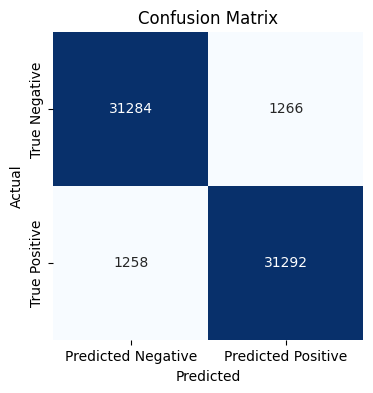

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin_AMR evaluation

(Phenotype prediction test)

Accuracy:  0.95
ROC-AUC:  0.95
Sensitivity:  0.9333333333333333
Specificity:  0.9666666666666667


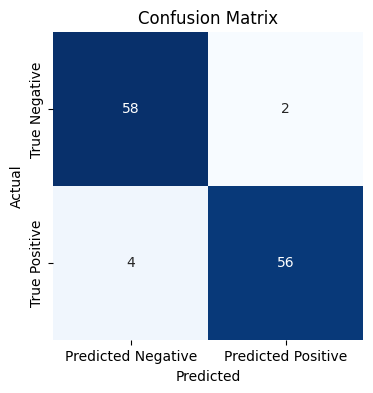

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 2

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
f

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

18404
5689
18404
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(18404, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5015 - auc-roc: 0.5027 - loss: 0.7805
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4911 - auc-roc: 0.4946 - loss: 0.7116
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5001 - auc-roc: 0.5006 - loss: 0.7021
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4932 - auc-roc: 0.4917 - loss: 0.7017
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5003 - auc-roc: 0.4959 - loss: 0.6986
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5089 - auc-roc: 0.5186 - loss: 0.6928
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7161 - auc-roc: 0.8065 - loss: 0.5296
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7563 - auc-roc: 0.8541 - loss: 0.4729
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7743 - auc-roc: 0.8658 - loss: 0.4552
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s

## Validation

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(train_set, train_labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

# 1 min

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA_Net evaluation

(Similarity test)

Accuracy:  0.9455606758832565
ROC-AUC:  0.9455606758832565
Sensitivity:  0.9505990783410139
Specificity:  0.9405222734254992


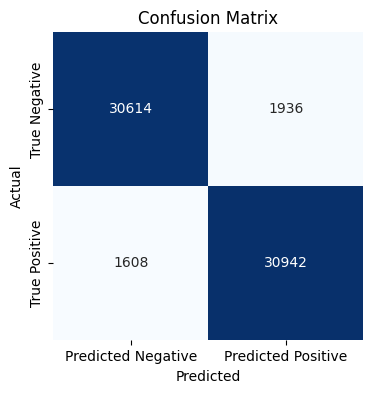

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin_AMR evaluation

(Phenotype prediction test)

Accuracy:  0.95
ROC-AUC:  0.95
Sensitivity:  0.9833333333333333
Specificity:  0.9166666666666666


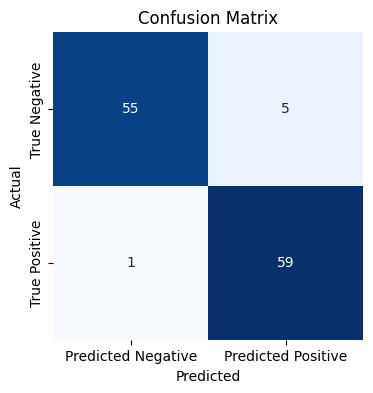

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 3

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for d

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

18404
5689
18404
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(18404, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.5044 - auc-roc: 0.5035 - loss: 0.7797
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5039 - auc-roc: 0.4965 - loss: 0.7113
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4984 - auc-roc: 0.4976 - loss: 0.7032
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5033 - auc-roc: 0.5048 - loss: 0.6989
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6900 - auc-roc: 0.7771 - loss: 0.5582
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7524 - auc-roc: 0.8477 - loss: 0.4823
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7820 - auc-roc: 0.8720 - loss: 0.4492
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8002 - auc-roc: 0.8873 - loss: 0.4256
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8152 - auc-roc: 0.8992 - loss: 0.4028
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s

## Validation

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(train_set, train_labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA_Net evaluation

(Similarity test)

Accuracy:  0.9353302611367128
ROC-AUC:  0.9353302611367128
Sensitivity:  0.9652534562211982
Specificity:  0.9054070660522273


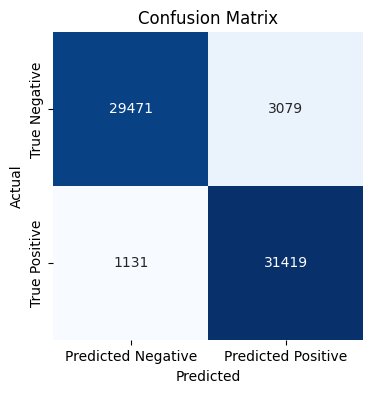

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin_AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9583333333333334
ROC-AUC:  0.9583333333333333
Sensitivity:  1.0
Specificity:  0.9166666666666666


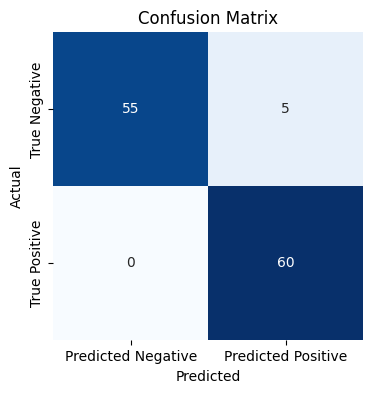

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 4

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for d

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

18404
5689
18404
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(18404, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.4952 - auc-roc: 0.4990 - loss: 0.7896
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5014 - auc-roc: 0.5019 - loss: 0.7132
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6338 - auc-roc: 0.6951 - loss: 0.6209
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7424 - auc-roc: 0.8382 - loss: 0.4913
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7579 - auc-roc: 0.8550 - loss: 0.4684
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7901 - auc-roc: 0.8805 - loss: 0.4358
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8222 - auc-roc: 0.9077 - loss: 0.3858
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8358 - auc-roc: 0.9198 - loss: 0.3601
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8444 - auc-roc: 0.9280 - loss: 0.3414
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s

## Validation

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(train_set, train_labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

## TSA_Net evaluation

(Similarity test)

Accuracy:  0.9266666666666666
ROC-AUC:  0.9266666666666666
Sensitivity:  0.9352688172043011
Specificity:  0.9180645161290323


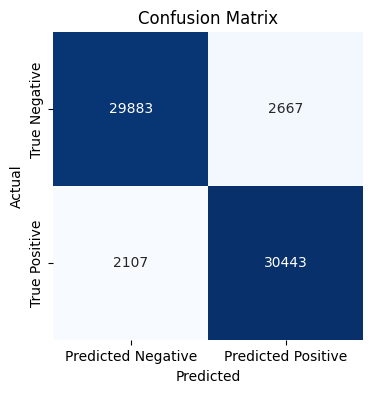

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin_AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9416666666666667
ROC-AUC:  0.9416666666666667
Sensitivity:  0.95
Specificity:  0.9333333333333333


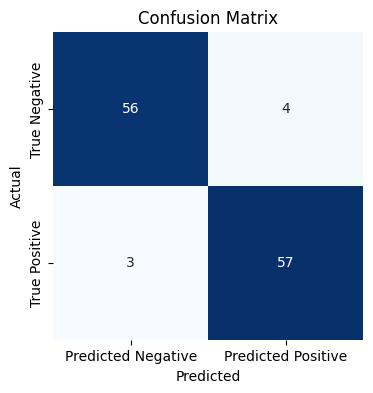

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 5

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for d

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

18404
5689
18404
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(18404, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.5034 - auc-roc: 0.5112 - loss: 0.7985
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4987 - auc-roc: 0.4983 - loss: 0.7170
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5029 - auc-roc: 0.5041 - loss: 0.7050
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5074 - auc-roc: 0.5050 - loss: 0.7014
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4960 - auc-roc: 0.4966 - loss: 0.7003
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4948 - auc-roc: 0.4965 - loss: 0.6981
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5945 - auc-roc: 0.6476 - loss: 0.6401
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7383 - auc-roc: 0.8399 - loss: 0.4853
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7741 - auc-roc: 0.8636 - loss: 0.4570
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2

## Validation

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(train_set, train_labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
print(internal_labels[0])
print(internal_preds[0])

1
[0.9999959468841553]


In [ ]:
print(len(internal_labels))
print(internal_labels[0])
print(type(internal_labels[0]))

65100
1
<class 'int'>


In [ ]:
print(len(internal_preds))
print(internal_preds[0])
print(type(internal_preds[0]))

65100
[0.9999959468841553]
<class 'list'>


In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA_Net evaluation

(Similarity test)

Accuracy:  0.9618125960061444
ROC-AUC:  0.9618125960061444
Sensitivity:  0.9648847926267281
Specificity:  0.9587403993855607


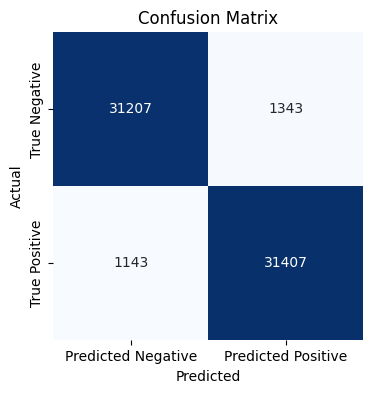

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin_AMR evaluation

(Phenotype prediction test)

Accuracy:  0.975
ROC-AUC:  0.9750000000000001
Sensitivity:  0.9833333333333333
Specificity:  0.9666666666666667


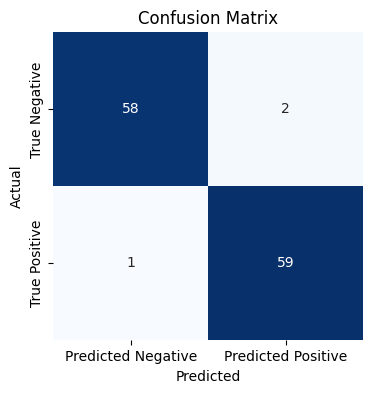

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 6

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
f

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

18404
5689
18404
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(18404, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4971 - auc-roc: 0.4931 - loss: 0.8224
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4963 - auc-roc: 0.5035 - loss: 0.7129
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5009 - auc-roc: 0.4997 - loss: 0.7066
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5034 - auc-roc: 0.5032 - loss: 0.7005
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5058 - auc-roc: 0.5033 - loss: 0.6981
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5824 - auc-roc: 0.6285 - loss: 0.6497
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7481 - auc-roc: 0.8456 - loss: 0.4841
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7912 - auc-roc: 0.8784 - loss: 0.4409
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8018 - auc-roc: 0.8917 - loss: 0.4146
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s

## Validation

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(train_set, train_labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA_Net evaluation

(Similarity test)

Accuracy:  0.9318125960061444
ROC-AUC:  0.9318125960061445
Sensitivity:  0.9660522273425499
Specificity:  0.8975729646697389


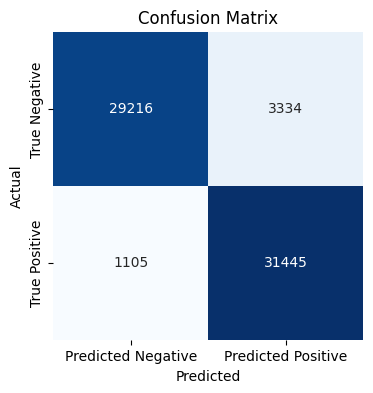

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin_AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9583333333333334
ROC-AUC:  0.9583333333333334
Sensitivity:  0.9666666666666667
Specificity:  0.95


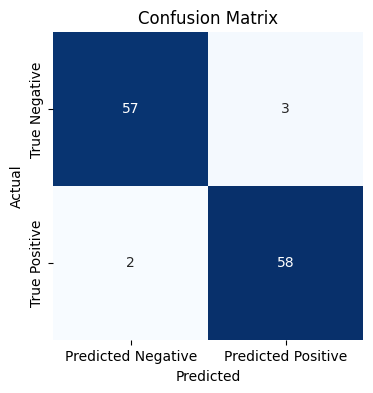

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 7

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
f

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

18404
5689
18404
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(18404, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.5044 - auc-roc: 0.5036 - loss: 0.7863
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4961 - auc-roc: 0.4937 - loss: 0.7140
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4966 - auc-roc: 0.4966 - loss: 0.7039
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4959 - auc-roc: 0.4994 - loss: 0.6988
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5032 - auc-roc: 0.5036 - loss: 0.6973
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5026 - auc-roc: 0.5022 - loss: 0.6960
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4981 - auc-roc: 0.5033 - loss: 0.6951
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5437 - auc-roc: 0.5729 - loss: 0.6706
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7376 - auc-roc: 0.8335 - loss: 0.4972
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s

## Validation

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(train_set, train_labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA_Net evaluation

(Similarity test)

Accuracy:  0.9404608294930875
ROC-AUC:  0.9404608294930876
Sensitivity:  0.9594162826420891
Specificity:  0.921505376344086


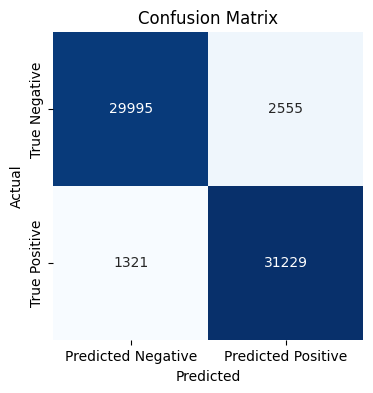

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin_AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9583333333333334
ROC-AUC:  0.9583333333333334
Sensitivity:  0.9666666666666667
Specificity:  0.95


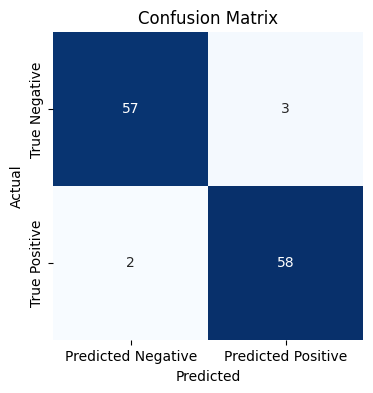

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 8

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
f

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

18404
5689
18404
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(18404, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.4977 - auc-roc: 0.5033 - loss: 0.8049
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4895 - auc-roc: 0.4877 - loss: 0.7140
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5008 - auc-roc: 0.4964 - loss: 0.7036
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5056 - auc-roc: 0.5057 - loss: 0.6985
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5289 - auc-roc: 0.5437 - loss: 0.6853
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7141 - auc-roc: 0.8111 - loss: 0.5197
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7474 - auc-roc: 0.8475 - loss: 0.4742
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7733 - auc-roc: 0.8703 - loss: 0.4465
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8001 - auc-roc: 0.8931 - loss: 0.4095
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s

## Validation

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(train_set, train_labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA_Net evaluation

(Similarity test)

Accuracy:  0.8965745007680491
ROC-AUC:  0.8965745007680492
Sensitivity:  0.95963133640553
Specificity:  0.8335176651305684


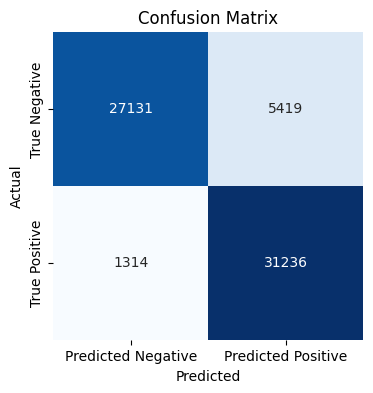

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin_AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9083333333333333
ROC-AUC:  0.9083333333333334
Sensitivity:  0.9833333333333333
Specificity:  0.8333333333333334


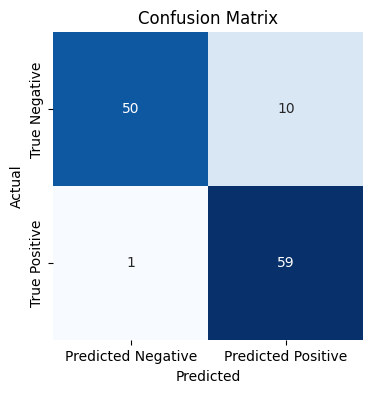

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 9

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
f

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

18404
5689
18404
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(18404, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5005 - auc-roc: 0.5074 - loss: 0.7771
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5029 - auc-roc: 0.5078 - loss: 0.7073
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5019 - auc-roc: 0.4997 - loss: 0.7034
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4981 - auc-roc: 0.5030 - loss: 0.6995
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4971 - auc-roc: 0.4947 - loss: 0.6980
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4993 - auc-roc: 0.4957 - loss: 0.6965
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4974 - auc-roc: 0.4933 - loss: 0.6957
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5019 - auc-roc: 0.5092 - loss: 0.6938
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6987 - auc-roc: 0.7762 - loss: 0.5640
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s

## Validation

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(train_set, train_labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA_Net evaluation

(Similarity test)

Accuracy:  0.9133333333333333
ROC-AUC:  0.9133333333333333
Sensitivity:  0.9226728110599078
Specificity:  0.9039938556067588


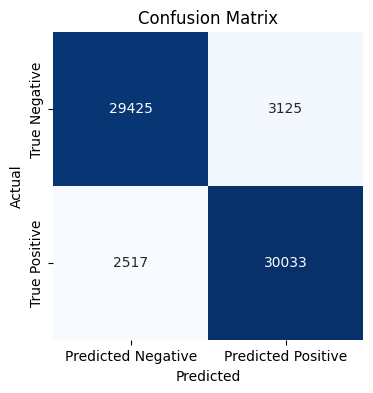

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin_AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9166666666666666
ROC-AUC:  0.9166666666666666
Sensitivity:  0.9
Specificity:  0.9333333333333333


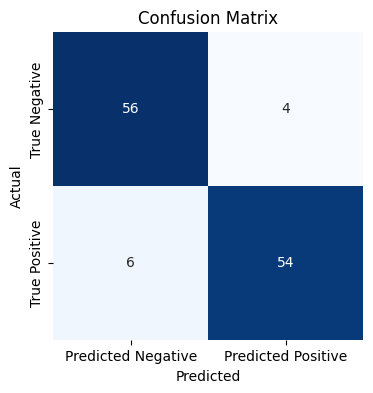

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Round 10

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
f

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

18404
5689
18404
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(18404, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.5029 - auc-roc: 0.5085 - loss: 0.7890
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4891 - auc-roc: 0.4884 - loss: 0.7141
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5019 - auc-roc: 0.5024 - loss: 0.7031
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5051 - auc-roc: 0.5059 - loss: 0.6993
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5055 - auc-roc: 0.5044 - loss: 0.6973
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5635 - auc-roc: 0.5969 - loss: 0.6650
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7433 - auc-roc: 0.8393 - loss: 0.4886
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7713 - auc-roc: 0.8646 - loss: 0.4577
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7984 - auc-roc: 0.8886 - loss: 0.4205
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s

## Validation

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(train_set, train_labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data


for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA_Net evaluation

(Similarity test)

Accuracy:  0.93678955453149
ROC-AUC:  0.9367895545314899
Sensitivity:  0.9612596006144393
Specificity:  0.9123195084485407


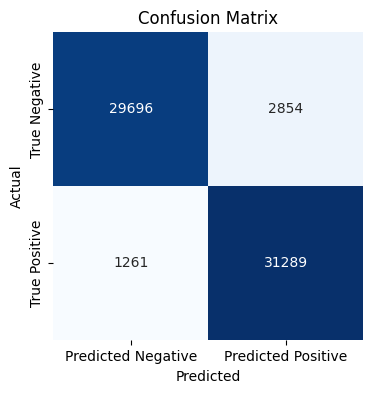

In [ ]:
acc, auc, sen, spc = evaluation(internal_labels, internal_preds)

In [ ]:
sim_acc.append(acc)
sim_auc.append(auc)
sim_sen.append(sen)
sim_spc.append(spc)

## TripSimAcin_AMR evaluation

(Phenotype prediction test)

Accuracy:  0.9416666666666667
ROC-AUC:  0.9416666666666668
Sensitivity:  0.9833333333333333
Specificity:  0.9


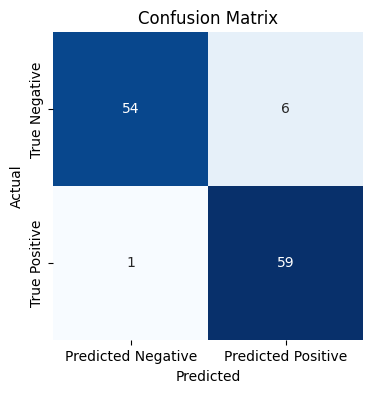

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
phen_acc.append(acc)
phen_auc.append(auc)
phen_sen.append(sen)
phen_spc.append(spc)

# Results

In [ ]:
print("similarity accuracies: ", sim_acc)
print("average: ", sum(sim_acc)/len(sim_acc))

similarity accuracies:  [0.9612288786482335, 0.9455606758832565, 0.9353, 0.9266, 0.9618, 0.9318125960061444, 0.9404608294930875, 0.8965745007680491, 0.9133333333333333, 0.93678955453149]
averrage:  0.9349460368663595


- Mean: 0.935

In [ ]:
print("similarity aucs: ", sim_auc)
print("average: ", sum(sim_auc)/len(sim_auc))

similarity aucs:  [0.9612288786482334, 0.9455606758832565, 0.9353, 0.9266, 0.9618, 0.9318125960061445, 0.9404608294930876, 0.8965745007680492, 0.9133333333333333, 0.9367895545314899]
averrage:  0.9349460368663595


- Mean: 0.935

In [ ]:
print("similarity sensitivities: ", sim_sen)
print("average: ", sum(sim_sen)/len(sim_sen))

similarity sensitivities:  [0.9613517665130569, 0.9505990783410139, 0.9652, 0.9352, 0.9648, 0.9660522273425499, 0.9594162826420891, 0.95963133640553, 0.9226728110599078, 0.9612596006144393]
averrage:  0.9546183102918588


- Mean: 0.9545

In [ ]:
print("similarity specificities: ", sim_spc)
print("average: ", sum(sim_spc)/len(sim_spc))

similarity specificities:  [0.9611059907834102, 0.9405222734254992, 0.9, 0.918, 0.9587, 0.8975729646697389, 0.921505376344086, 0.8335176651305684, 0.9039938556067588, 0.9123195084485407]
averrage:  0.9147237634408603


- Mean: 0.9147

In [ ]:
print("Phenotype accuracies: ", phen_acc)
print("average: ", sum(phen_acc)/len(phen_acc))

Phenotype accuracies:  [0.95, 0.95, 0.9583, 0.9416, 0.975, 0.9583333333333334, 0.9583333333333334, 0.9083333333333333, 0.9166666666666666, 0.9416666666666667]
averrage:  0.9458233333333332


- Mean: 0.94

In [ ]:
print("Phenotype aucs: ", phen_auc)
print("average: ", sum(phen_auc)/len(phen_auc))

Phenotype aucs:  [0.95, 0.95, 0.9583, 0.9416, 0.975, 0.9583333333333334, 0.9583333333333334, 0.9083333333333334, 0.9166666666666666, 0.9416666666666668]
averrage:  0.9458233333333332


- Mean: 0.94


In [ ]:
print("Phenotype sensitivities: ", phen_sen)
print("average: ", sum(phen_sen)/len(phen_sen))

Phenotype sensitivities:  [0.9333333333333333, 0.9833333333333333, 1.0, 0.95, 0.9833, 0.9666666666666667, 0.9666666666666667, 0.9833333333333333, 0.9, 0.9833333333333333]
averrage:  0.9649966666666666


- Mean: 0.96

In [ ]:
print("Phenotype specificities: ", phen_spc)
print("average: ", sum(phen_spc)/len(phen_spc))

Phenotype specificities:  [0.9666666666666667, 0.9166666666666666, 0.9166, 0.9333, 0.9666, 0.95, 0.95, 0.8333333333333334, 0.9333333333333333, 0.9]
averrage:  0.9266500000000001


- Mean: 0.92